In [1]:
import os
#%pip uninstall -y numpy
#%pip install -U numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import math
from sklearn.model_selection import train_test_split

### Load all the individual HUPA00xx.csv into df1, df2, etc.

In [2]:
# Set the directory path where the CSV files are located
dir_path = "Preprocessed"

# Create an empty list to store the dataframes
dfs = []

# Iterate over the files in the directory
for i in range(1, 26):
    # Construct the file name with zero-padding
    file_name = f"HUPA{str(i).zfill(4)}P.csv"
    
    # Join the directory path and file name
    file_path = os.path.join(dir_path, file_name)
    
    # Load the CSV file into a dataframe
    df = pd.read_csv(file_path, sep=";")
    
    # Append the dataframe to the list
    dfs.append(df)

# Assign the dataframes to individual variables
for i, df in enumerate(dfs, start=1):
    globals()[f"df{i}"] = df

In [3]:
from copy import deepcopy
df1copy = df1.copy(deep=True)
df1

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
0,2018-06-13T18:40:00,332.000000,6.3595,82.322835,34.0,0.091667,0.0,0.0
1,2018-06-13T18:45:00,326.000000,7.7280,83.740157,0.0,0.091667,0.0,0.0
2,2018-06-13T18:50:00,330.000000,4.7495,80.525180,0.0,0.091667,0.0,0.0
3,2018-06-13T18:55:00,324.000000,6.3595,89.129032,20.0,0.091667,0.0,0.0
4,2018-06-13T19:00:00,306.000000,5.1520,92.495652,0.0,0.075000,0.0,0.0
...,...,...,...,...,...,...,...,...
4091,2018-06-27T23:35:00,323.666667,5.2325,88.051724,0.0,0.058333,1.0,0.0
4092,2018-06-27T23:40:00,325.333333,4.1055,77.680672,0.0,0.058333,0.0,0.0
4093,2018-06-27T23:45:00,327.000000,4.0250,79.358974,0.0,0.058333,0.0,0.0
4094,2018-06-27T23:50:00,326.000000,4.1055,82.058333,0.0,0.058333,0.0,0.0


### Train-test split

In [4]:
glucose_data = df1["glucose"]
train_size = int(len(glucose_data) * 0.8)
train, test = glucose_data.iloc[:train_size], glucose_data.iloc[train_size:]
train_reshaped = np.array(train).reshape((train.shape[0], 1, 1))

### Create train sequences for LSTM

In [5]:
# Set the number of time steps (i.e., how many past time steps to use for prediction)
n_timesteps = 12  # This means using the last 12 time steps to predict the next glucose level

# Function to create sequences from the glucose data
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        # Extract a sequence of length n_timesteps
        X.append(data[i:i + n_timesteps])
        # The target (label) is the next time step's glucose value
        y.append(data[i + n_timesteps])
    return np.array(X), np.array(y)

# Extract the glucose data from df1
glucose_data = df1["glucose"].values

# Create the sequences
train_features, train_target = create_sequences(glucose_data, n_timesteps)

# Reshape train_features
train_features = train_features.reshape((train_features.shape[0], n_timesteps, 1))

### From train, create X_train and X_test based on features. Create y_train and y_test based on and target values.

In [6]:
# Split the reshaped data into training and test sets
split_index = int(0.8 * len(train_features))

X_train, X_test = train_features[:split_index], train_features[split_index:]
y_train, y_test = train_target[:split_index], train_target[split_index:]

# Reshape X_test to match X_train
X_test = X_test.reshape((X_test.shape[0], n_timesteps, 1))

# Check the shapes of the resulting arrays
print(f"train_features shape: {train_features.shape}")  # (samples, timesteps)
print(f"train_target shape: {train_target.shape}")      # (samples,)

train_features shape: (4084, 12, 1)
train_target shape: (4084,)


In [17]:
# Define the LSTM with attention model
"""
def build_lstm_attention_model(input_shape):
    # Input layer (expects 3D input: [samples, timesteps, features])
    inputs = Input(shape=input_shape)

    # LSTM layer (return_sequences=True because we need to pass all timesteps to Attention)
    lstm_out = LSTM(64, return_sequences=True)(inputs)

    # Attention layer
    attention_out, attention_weights = Attention()([lstm_out, lstm_out])

    # Fully connected layer (time-distributed output)
    output = TimeDistributed(Dense(1))(attention_out)

    # Build the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    return model
"""

### Define LSTM with attention. Save attention weights.

In [7]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Permute, Multiply, Lambda
from keras.models import Model
import keras.backend as K
from keras.activations import tanh, softmax
import tensorflow as tf

# Custom attention layer
def attention_3d_block(hidden_states):
    # Hidden states of LSTM have shape (batch_size, timesteps, hidden_size)
    hidden_size = int(hidden_states.shape[2])

    # Dense layer to learn the attention weights
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    
    # Apply tanh non-linearity
    h_tanh = tanh(score_first_part)

    # Another Dense layer to compute the attention weights
    attention_weights = Dense(1, use_bias=False, name='attention_weight')(h_tanh)
    
    # Apply softmax to normalize attention weights
    attention_weights = softmax(attention_weights, axis=1)

    # Multiply attention weights with the hidden states to get the context vector
    context_vector = Multiply()([hidden_states, attention_weights])
    
    # Sum the context vector along the time axis using Lambda layer
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

    return context_vector, attention_weights

# Define the LSTM with custom attention model
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM layer
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    
    # Attention mechanism
    context_vector, attention_weights = attention_3d_block(lstm_out)
    
    # Dense layer to make predictions
    output = Dense(1)(context_vector)
    
    # Build the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model

### Instantiate the model and display model summary

In [19]:
# Define the input shape for the model (timesteps, features)
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the model
model = build_lstm_attention_model(input_shape)

# Display the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score_vec │ (None, 12, 64)    │      4,096 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tanh (Tanh)         │ (None, 12, 64)    │          0 │ attention_score_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 12, 1)     │         64 │ tanh[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 12, 1)     │          0 │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 12, 64)    │          0 │ lstm[0][0],       │
│                     │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,121 (82.50 KB)

 Trainable params: 21,121 (82.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train the LSTM/Attention model

In [22]:
# Fit the LSTM with attention model on the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 761.4800 - val_loss: 351.1162
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 784.4729 - val_loss: 330.0182
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 736.8442 - val_loss: 280.9143
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 710.7460 - val_loss: 244.9493
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 677.5058 - val_loss: 224.4842
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 667.7310 - val_loss: 215.4025
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 618.6476 - val_loss: 214.5028
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 537.2870 - val_loss: 197.2267
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 555.3357 - val_loss: 184.6327
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 526.4224 - val_loss: 173.9399
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 486.6308 - val_loss: 170.38

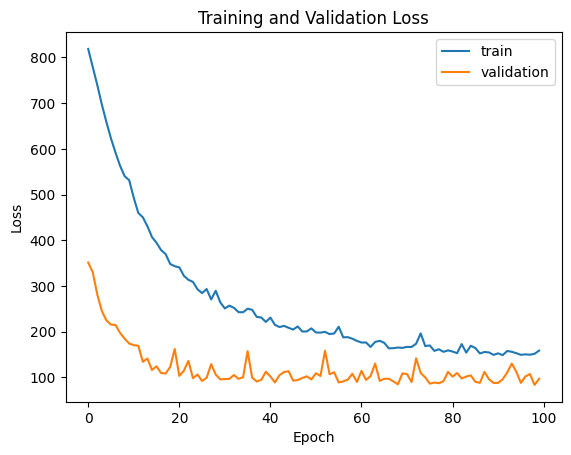

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Display the attention weights

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


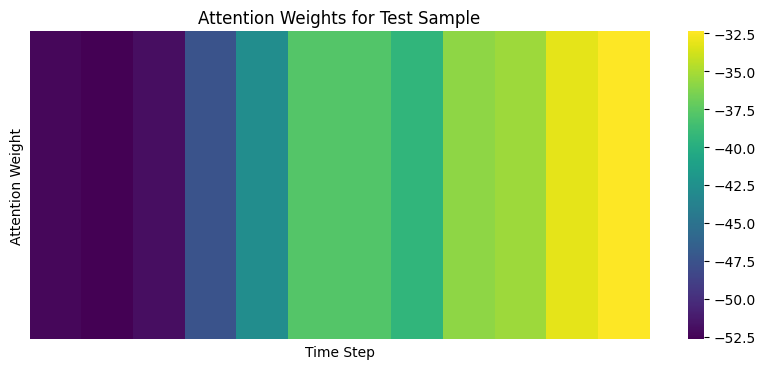

In [27]:
# Extract attention weights from the model, computed from the 'attention_weight' layer
attention_extractor = Model(inputs=model.input, outputs=model.get_layer('attention_weight').output)

# Get attention weights for the test set
# This will return the attention weights for all samples
attention_weights = attention_extractor.predict(X_test)

# Visualize attention weights for a specific test sample
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a sample to visualize (e.g., the first test sample)
sample_idx = 0
attention_map = attention_weights[sample_idx, :, 0]  # Remove the last dimension if it's 1

# Plot the attention weights (heatmap)
plt.figure(figsize=(10, 4))
sns.heatmap(attention_map.reshape(1, -1), cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Attention Weights for Test Sample')
plt.xlabel('Time Step')
plt.ylabel('Attention Weight')
plt.show()

### Display model prediction on the test set, compared with actual data

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


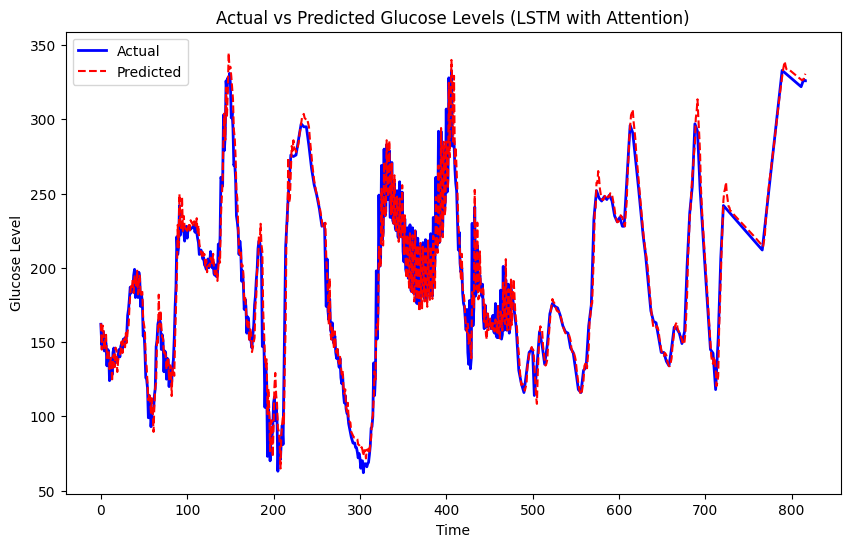

In [26]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the true values vs. predicted values
plt.figure(figsize=(10, 6))

# Plot actual glucose levels
plt.plot(y_test.flatten(), label='Actual', color='blue', linewidth=2)

# Plot predicted glucose levels
plt.plot(y_pred.flatten(), label='Predicted', color='red', linestyle='--')

plt.title('Actual vs Predicted Glucose Levels (LSTM with Attention)')
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()

In [29]:
attention_weights.shape

(817, 12, 1)

### Something to consider if there is time: Bidirectional LSTM/attention

In [ ]:
from keras.layers import Bidirectional

# Consider Bidirectional LSTM with attention
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)